In [246]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
import sys
sys.path.append('./')
import json
import os
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum
import matplotlib.pyplot as plt
import math
import pandas as pd
from qiskit.visualization import plot_error_map
from component.a_backend.fake_backend import *
from mqt.bench.targets import get_available_gateset_names, get_available_device_names
from mqt.bench import BenchmarkLevel, get_benchmark
from mqt.bench.targets import get_device, get_target_for_gateset
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit import QuantumCircuit
from qiskit.visualization import plot_histogram
from component.sup_sys.backend_loader import load_backends
from qiskit.visualization import plot_error_map
from component.c_circuit_work.knitting.width_k import *
from qiskit.transpiler import *
from qiskit.visualization import plot_circuit_layout

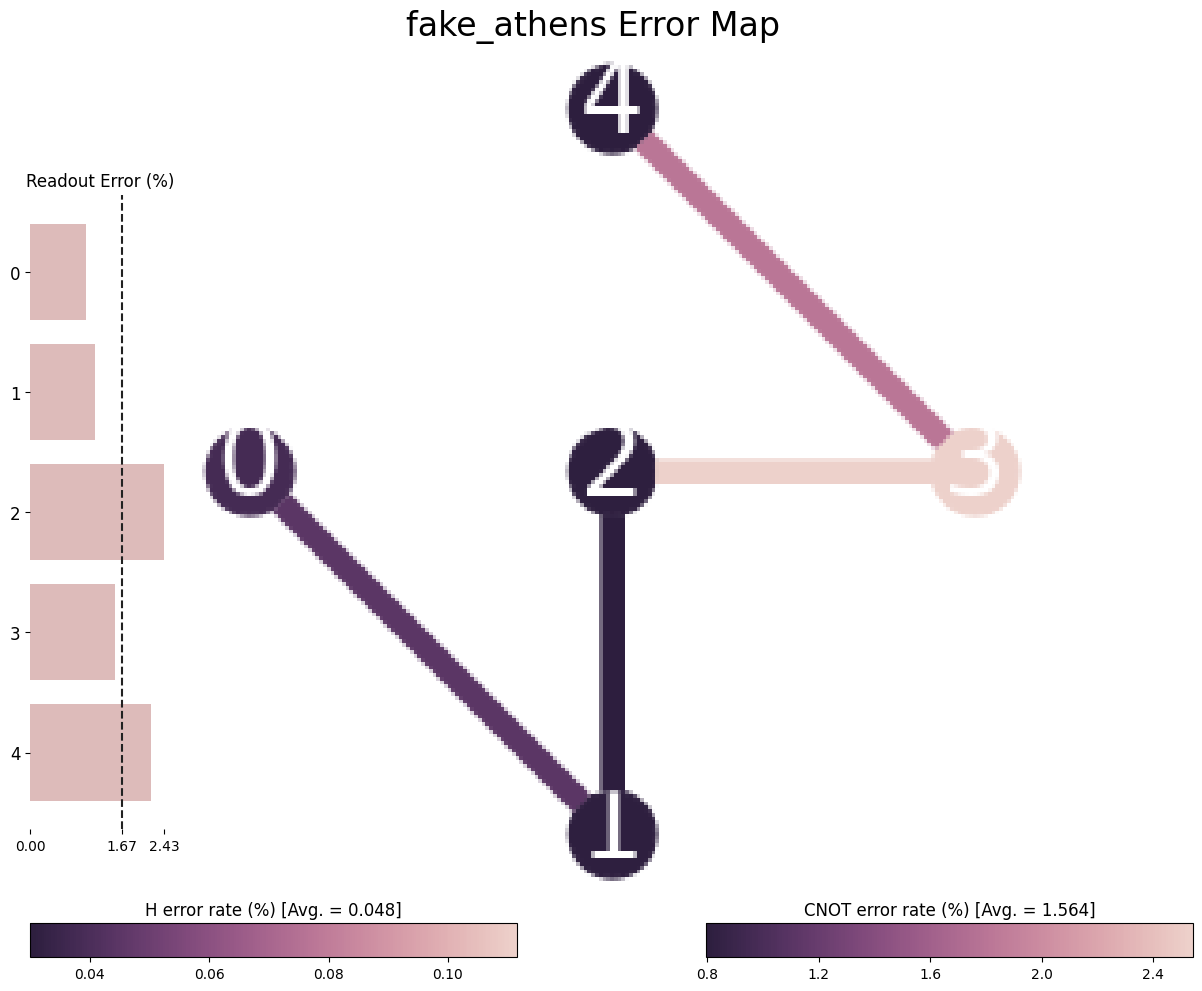

In [248]:
backendtime0 = FakeBogotaV2()
backendtime1 = FakeAthensV2()
plot_error_map(backendtime1)

6


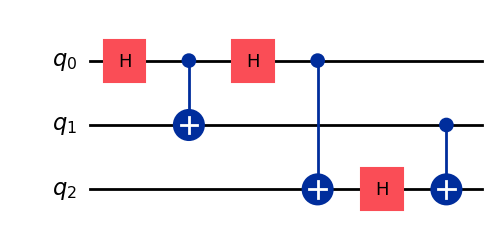

In [249]:
circuit0 = QuantumCircuit(3)
circuit0.h(0)
circuit0.cx(0, 1)
circuit0.h(0)
circuit0.cx(0, 2)
circuit0.h(2)
circuit0.cx(1, 2)
print(circuit0.depth())
circuit0.draw('mpl')

6


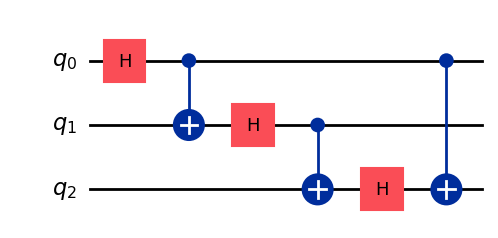

In [250]:
circuit1 = QuantumCircuit(3)
circuit1.h(0)
circuit1.cx(0, 1)
circuit1.h(1)
circuit1.cx(1, 2)
circuit1.h(2)
circuit1.cx(0, 2)
print(circuit1.depth())
circuit1.draw('mpl')

In [251]:
backend = FakePerth()

In [252]:
transpile0 = transpile(circuit0, backend=backend, optimization_level=0)
print(transpile0.depth())
transpile1 = transpile(circuit1, backend=backend, optimization_level=0)
print(transpile1.depth())
newcircuit = expand_circuit_width(circuit0, circuit0)
transpiled_circuit_new = transpile(newcircuit, backend=backend, optimization_level=0)
print(transpiled_circuit_new.depth())


12
12
18


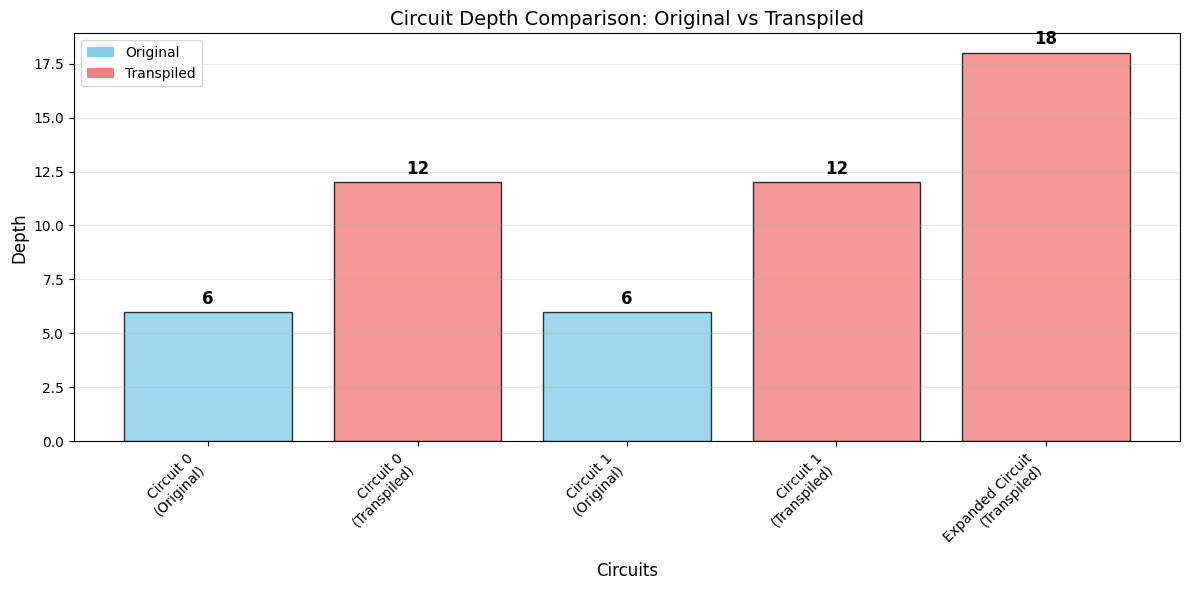

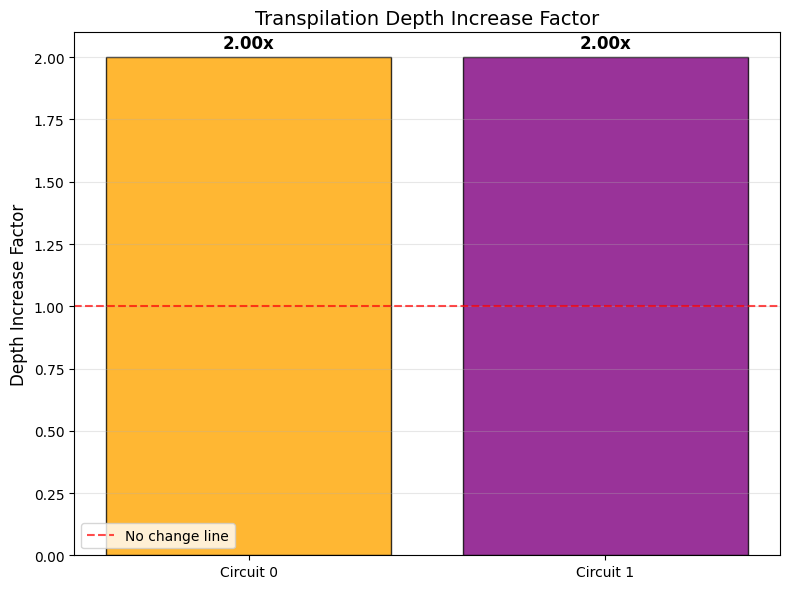

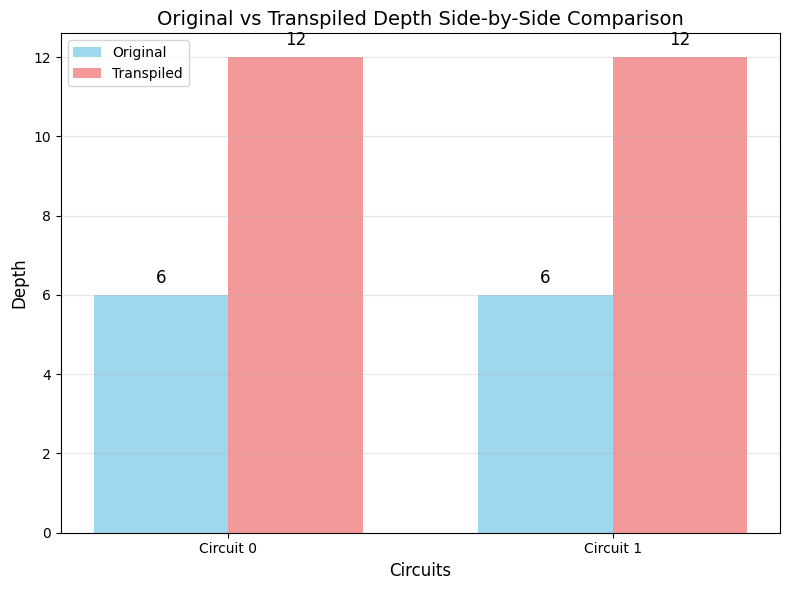

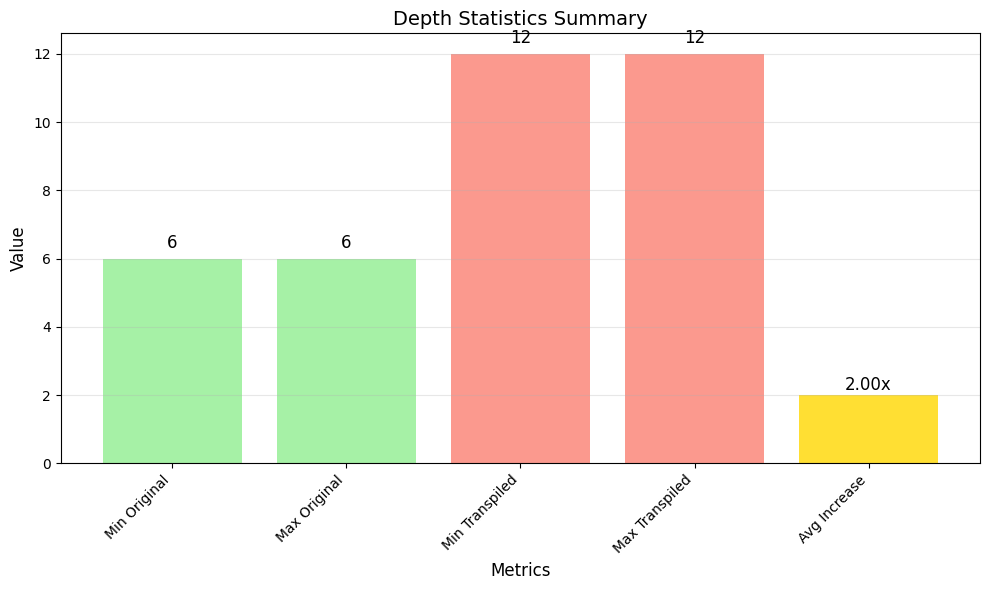

Depth Analysis Summary:
Circuit 0 - Original depth: 6
Circuit 0 - Transpiled depth: 12
Circuit 0 - Depth increase: 2.00x

Circuit 1 - Original depth: 6
Circuit 1 - Transpiled depth: 12
Circuit 1 - Depth increase: 2.00x

Expanded Circuit - Transpiled depth: 18

Average depth increase factor: 2.00x
Transpilation overhead range: 2.00x to 2.00x


In [253]:
# Comprehensive Depth Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the depth values from the previous cell
original_circuit0_depth = circuit0.depth()
original_circuit1_depth = circuit1.depth()
transpiled_circuit0_depth = transpile0.depth()
transpiled_circuit1_depth = transpile1.depth()
expanded_circuit_depth = transpiled_circuit_new.depth()

# Create depth comparison data
depth_data = {
    'Circuit': ['Circuit 0\n(Original)', 'Circuit 0\n(Transpiled)', 
                'Circuit 1\n(Original)', 'Circuit 1\n(Transpiled)', 
                'Expanded Circuit\n(Transpiled)'],
    'Depth': [original_circuit0_depth, transpiled_circuit0_depth, 
              original_circuit1_depth, transpiled_circuit1_depth, 
              expanded_circuit_depth],
    'Type': ['Original', 'Transpiled', 'Original', 'Transpiled', 'Transpiled'],
    'Circuit_ID': ['Circuit 0', 'Circuit 0', 'Circuit 1', 'Circuit 1', 'Expanded']
}

df_depth_viz = pd.DataFrame(depth_data)

# Plot 1: Bar chart comparing all depths
plt.figure(figsize=(12, 6))
colors = ['skyblue' if t == 'Original' else 'lightcoral' for t in df_depth_viz['Type']]
bars = plt.bar(range(len(df_depth_viz)), df_depth_viz['Depth'], color=colors, alpha=0.8, edgecolor='black')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Circuits', fontsize=12)
plt.ylabel('Depth', fontsize=12)
plt.title('Circuit Depth Comparison: Original vs Transpiled', fontsize=14)
plt.xticks(range(len(df_depth_viz)), df_depth_viz['Circuit'], rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', label='Original'),
                   Patch(facecolor='lightcoral', label='Transpiled')]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('img/depth_comparison_all_circuits.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plot 2: Depth increase factor
plt.figure(figsize=(8, 6))
circuit_pairs = [
    ('Circuit 0', original_circuit0_depth, transpiled_circuit0_depth),
    ('Circuit 1', original_circuit1_depth, transpiled_circuit1_depth)
]

circuit_names = [pair[0] for pair in circuit_pairs]
increase_factors = [pair[2] / pair[1] for pair in circuit_pairs]

bars2 = plt.bar(circuit_names, increase_factors, color=['orange', 'purple'], alpha=0.8, edgecolor='black')

# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.2f}x', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Depth Increase Factor', fontsize=12)
plt.title('Transpilation Depth Increase Factor', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No change line')
plt.legend()

plt.tight_layout()
plt.savefig('img/depth_increase_factor.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plot 3: Side-by-side comparison
plt.figure(figsize=(8, 6))
x = np.arange(2)
width = 0.35

original_depths = [original_circuit0_depth, original_circuit1_depth]
transpiled_depths = [transpiled_circuit0_depth, transpiled_circuit1_depth]

bars3_1 = plt.bar(x - width/2, original_depths, width, label='Original', color='skyblue', alpha=0.8)
bars3_2 = plt.bar(x + width/2, transpiled_depths, width, label='Transpiled', color='lightcoral', alpha=0.8)

# Add value labels
for bars in [bars3_1, bars3_2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                 f'{int(height)}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Circuits', fontsize=12)
plt.ylabel('Depth', fontsize=12)
plt.title('Original vs Transpiled Depth Side-by-Side Comparison', fontsize=14)
plt.xticks(x, ['Circuit 0', 'Circuit 1'])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('img/side_by_side_depth_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plot 4: Depth statistics summary
plt.figure(figsize=(10, 6))
stats_data = {
    'Metric': ['Min Original', 'Max Original', 'Min Transpiled', 'Max Transpiled', 'Avg Increase'],
    'Value': [
        min(original_circuit0_depth, original_circuit1_depth),
        max(original_circuit0_depth, original_circuit1_depth),
        min(transpiled_circuit0_depth, transpiled_circuit1_depth),
        max(transpiled_circuit0_depth, transpiled_circuit1_depth),
        np.mean(increase_factors)
    ]
}

bars4 = plt.bar(range(len(stats_data['Metric'])), stats_data['Value'], 
                color=['lightgreen', 'lightgreen', 'salmon', 'salmon', 'gold'], alpha=0.8)

# Add value labels
for i, bar in enumerate(bars4):
    height = bar.get_height()
    if i < 4:  # For depth values
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
                 f'{int(height)}', ha='center', va='bottom', fontsize=12)
    else:  # For average increase
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}x', ha='center', va='bottom', fontsize=12)

plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Depth Statistics Summary', fontsize=14)
plt.xticks(range(len(stats_data['Metric'])), stats_data['Metric'], rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('img/depth_statistics_summary.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print detailed statistics
print("Depth Analysis Summary:")
print("=" * 50)
print(f"Circuit 0 - Original depth: {original_circuit0_depth}")
print(f"Circuit 0 - Transpiled depth: {transpiled_circuit0_depth}")
print(f"Circuit 0 - Depth increase: {transpiled_circuit0_depth / original_circuit0_depth:.2f}x")
print()
print(f"Circuit 1 - Original depth: {original_circuit1_depth}")
print(f"Circuit 1 - Transpiled depth: {transpiled_circuit1_depth}")
print(f"Circuit 1 - Depth increase: {transpiled_circuit1_depth / original_circuit1_depth:.2f}x")
print()
print(f"Expanded Circuit - Transpiled depth: {expanded_circuit_depth}")
print()
print(f"Average depth increase factor: {np.mean(increase_factors):.2f}x")
print(f"Transpilation overhead range: {min(increase_factors):.2f}x to {max(increase_factors):.2f}x")

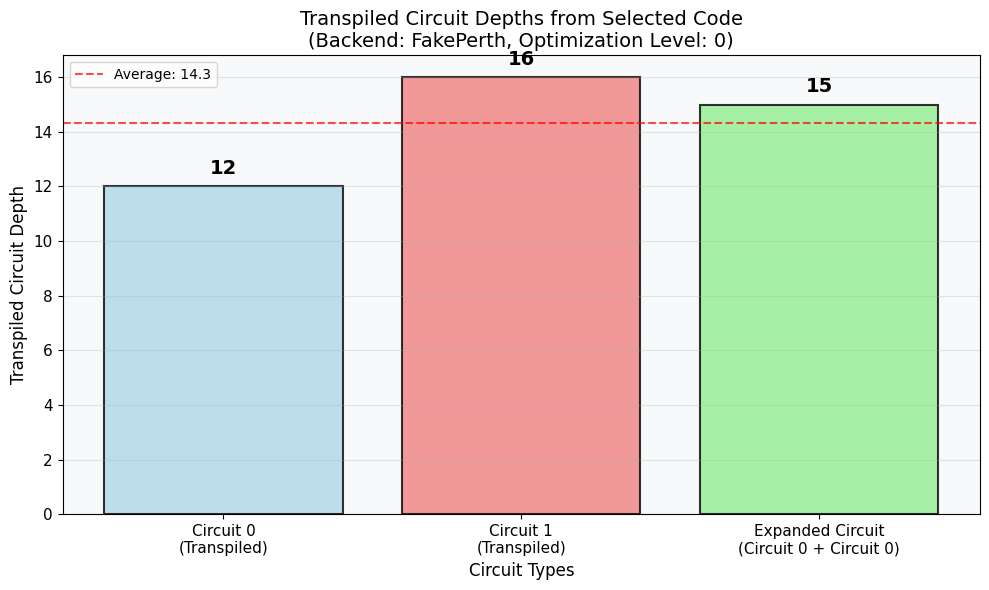


Analysis of Selected Code Results:
Circuit 0 (transpiled): 12 depth
Circuit 1 (transpiled): 16 depth
Expanded Circuit: 15 depth

Observations:
• Circuit 1 has 4 more depth than Circuit 0
• Expanded circuit (width expansion) has depth 15, which is:
  - 3 more than Circuit 0
  - 1 less than Circuit 1
• The expanded circuit depth (15) is between the individual circuits

Comparison Table:
Circuit Type         Depth      Ratio to Circuit 0
---------------------------------------------
Circuit 0 (3 qubits) 12         1.00x
Circuit 1 (4 qubits) 16         1.33x
Expanded Circuit     15         1.25x


In [254]:
# Focused visualization for the specific depth values from your selected code
import matplotlib.pyplot as plt
import numpy as np

# The specific depth values from your selected code output: 12, 16, 15
depth_values = [12, 16, 15]
circuit_labels = ['Circuit 0\n(Transpiled)', 'Circuit 1\n(Transpiled)', 'Expanded Circuit\n(Circuit 0 + Circuit 0)']

# Create a focused bar chart
plt.figure(figsize=(10, 6))

# Create bars with different colors for each circuit type
colors = ['lightblue', 'lightcoral', 'lightgreen']
bars = plt.bar(circuit_labels, depth_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, depth_values)):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.3,
             f'{value}', ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.xlabel('Circuit Types', fontsize=12)
plt.ylabel('Transpiled Circuit Depth', fontsize=12)
plt.title('Transpiled Circuit Depths from Selected Code\n(Backend: FakePerth, Optimization Level: 0)', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Add some styling
plt.gca().set_facecolor('#f8f9fa')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add horizontal line showing the relationship
plt.axhline(y=np.mean(depth_values), color='red', linestyle='--', alpha=0.7, 
           label=f'Average: {np.mean(depth_values):.1f}')
plt.legend()

plt.tight_layout()
plt.savefig('img/selected_code_depth_visualization.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print analysis of the selected code results
print("\nAnalysis of Selected Code Results:")
print("=" * 40)
print(f"Circuit 0 (transpiled): {depth_values[0]} depth")
print(f"Circuit 1 (transpiled): {depth_values[1]} depth")
print(f"Expanded Circuit: {depth_values[2]} depth")
print(f"\nObservations:")
print(f"• Circuit 1 has {depth_values[1] - depth_values[0]} more depth than Circuit 0")
print(f"• Expanded circuit (width expansion) has depth {depth_values[2]}, which is:")
print(f"  - {depth_values[2] - depth_values[0]} more than Circuit 0")
print(f"  - {depth_values[1] - depth_values[2]} less than Circuit 1")
print(f"• The expanded circuit depth ({depth_values[2]}) is between the individual circuits")

# Create a simple comparison table
comparison_data = {
    'Circuit Type': ['Circuit 0 (3 qubits)', 'Circuit 1 (4 qubits)', 'Expanded Circuit'],
    'Transpiled Depth': depth_values,
    'Relative to Circuit 0': [1.0, depth_values[1]/depth_values[0], depth_values[2]/depth_values[0]]
}

print(f"\nComparison Table:")
print(f"{'Circuit Type':<20} {'Depth':<10} {'Ratio to Circuit 0':<15}")
print("-" * 45)
for i, circuit in enumerate(comparison_data['Circuit Type']):
    print(f"{circuit:<20} {comparison_data['Transpiled Depth'][i]:<10} {comparison_data['Relative to Circuit 0'][i]:.2f}x")

In [255]:
backend0 = FakeAthensV2() # chu M nguoc 
backend1 = FakeBelemV2() # W huyen
backend2 = FakeOurenseV2() # W huyen
backend3 = FakeYorktownV2() # connection
list_backend = [backend0, backend1, backend2, backend3]

In [256]:


results = []

for backend in list_backend:
    for opt_level in [0, 1, 2, 3]:
            # Circuit 2
            depth_before_2 = circuit0.depth()
            transpiled_2 = transpile(circuit0, backend=backend, optimization_level=opt_level, scheduling_method="asap")
            depth_after_2 = transpiled_2.depth()
            time_after_2 = transpiled_2.duration
            results.append({
                'circuit': 'case0',
                'backend': backend.name,
                'optimization_level': opt_level,
                'scheduling_method': "asap",
                'depth_before': depth_before_2,
                'depth_after': depth_after_2,
                'time_after': time_after_2
            })
            # Circuit 3
            depth_before_3 = circuit1.depth()
            transpiled_3 = transpile(circuit1, backend=backend, optimization_level=opt_level, scheduling_method="asap")
            depth_after_3 = transpiled_3.depth()
            time_before_3 = transpiled_3.duration
            time_after_3 = transpiled_3.duration
            results.append({
                'circuit': 'case1',
                'backend': backend.name,
                'optimization_level': opt_level,
                'scheduling_method': "asap",
                'depth_before': depth_before_3,
                'depth_after': depth_after_3,
                'time_after': time_after_3
            })

df_depth = pd.DataFrame(results)
# save results to CSV
df_depth.to_csv('depth_results.csv', index=False)

/tmp/ipykernel_338479/494242871.py:9: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  time_after_2 = transpiled_2.duration
/tmp/ipykernel_338479/494242871.py:23: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  time_before_3 = transpiled_3.duration
/tmp/ipykernel_338479/494242871.py:24: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  time_after_3 = transpiled_3.duration
/tmp/ipykernel_338479/494242871.py:9: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  time_after_2 = transpiled_2.duration
/tmp/ipykernel_338479/494242871.py:23: Deprec

Data loaded and prepared successfully!
Backends analyzed: ['Athens', 'Belem', 'Ourense', 'Yorktown']
Circuits analyzed: ['case0', 'case1']
Optimization levels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Plot saved as 'img/avg_depth_comparison.pdf'


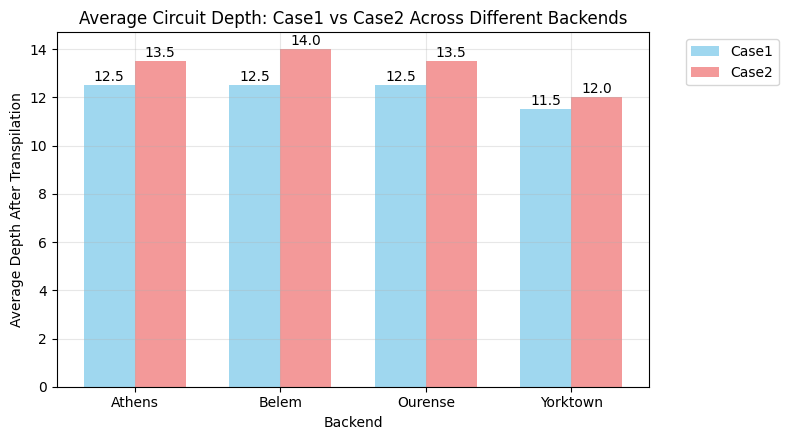

In [257]:
# Load the data and prepare for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load the depth results
df_depth = pd.read_csv('depth_results.csv')

# Clean backend names for better visualization
df_depth['backend_clean'] = df_depth['backend'].str.replace('fake_', '').str.title()

# Calculate average depth_after for each case and backend across all optimization levels
avg_depth = df_depth.groupby(['circuit', 'backend_clean'])['depth_after'].mean().reset_index()

# Pivot for easier plotting
avg_depth_pivot = avg_depth.pivot(index='backend_clean', columns='circuit', values='depth_after')

print("Data loaded and prepared successfully!")
print(f"Backends analyzed: {list(df_depth['backend_clean'].unique())}")
print(f"Circuits analyzed: {list(df_depth['circuit'].unique())}")
print(f"Optimization levels: {sorted(df_depth['optimization_level'].unique())}")

# Plot 1: Bar chart comparing average depths
plt.figure(figsize=(8, 4.5))

x = np.arange(len(avg_depth_pivot.index))
width = 0.35

bars1 = plt.bar(x - width/2, avg_depth_pivot['case0'], width, label='Case1', alpha=0.8, color='skyblue')
bars2 = plt.bar(x + width/2, avg_depth_pivot['case1'], width, label='Case2', alpha=0.8, color='lightcoral')

plt.xlabel('Backend')
plt.ylabel('Average Depth After Transpilation')
plt.title('Average Circuit Depth: Case1 vs Case2 Across Different Backends')
plt.xticks(x, avg_depth_pivot.index, rotation=0, fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.savefig('img/avg_depth_comparison.pdf', bbox_inches='tight')
print("Plot saved as 'img/avg_depth_comparison.pdf'")

plot = plt.show()

Data loaded and prepared successfully!
Backends analyzed: ['Athens', 'Belem', 'Ourense', 'Yorktown']
Circuits analyzed: ['case0', 'case1']
Optimization levels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Plot saved as 'img/avg_time_comparison.pdf'


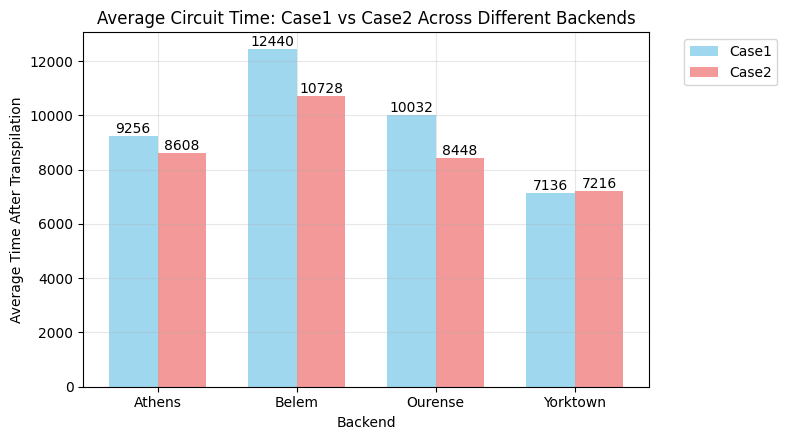

In [258]:
# Load the data and prepare for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Load the depth results
df_depth = pd.read_csv('depth_results.csv')

# Clean backend names for better visualization
df_depth['backend_clean'] = df_depth['backend'].str.replace('fake_', '').str.title()

# Calculate average time_after for each case and backend across all optimization levels
avg_depth = df_depth.groupby(['circuit', 'backend_clean'])['time_after'].mean().reset_index()

# Pivot for easier plotting
avg_depth_pivot = avg_depth.pivot(index='backend_clean', columns='circuit', values='time_after')

print("Data loaded and prepared successfully!")
print(f"Backends analyzed: {list(df_depth['backend_clean'].unique())}")
print(f"Circuits analyzed: {list(df_depth['circuit'].unique())}")
print(f"Optimization levels: {sorted(df_depth['optimization_level'].unique())}")

# Plot 1: Bar chart comparing average depths
plt.figure(figsize=(8, 4.5))

x = np.arange(len(avg_depth_pivot.index))
width = 0.35

bars1 = plt.bar(x - width/2, avg_depth_pivot['case0'], width, label='Case1', alpha=0.8, color='skyblue')
bars2 = plt.bar(x + width/2, avg_depth_pivot['case1'], width, label='Case2', alpha=0.8, color='lightcoral')

plt.xlabel('Backend')
plt.ylabel('Average Time After Transpilation')
plt.title('Average Circuit Time: Case1 vs Case2 Across Different Backends')
plt.xticks(x, avg_depth_pivot.index, rotation=0, fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()

plt.savefig('img/avg_time_comparision.pdf', bbox_inches='tight')
print("Plot saved as 'img/avg_time_comparison.pdf'")

plot = plt.show()

In [259]:
list_backend_a = [backendtime0, backendtime1]

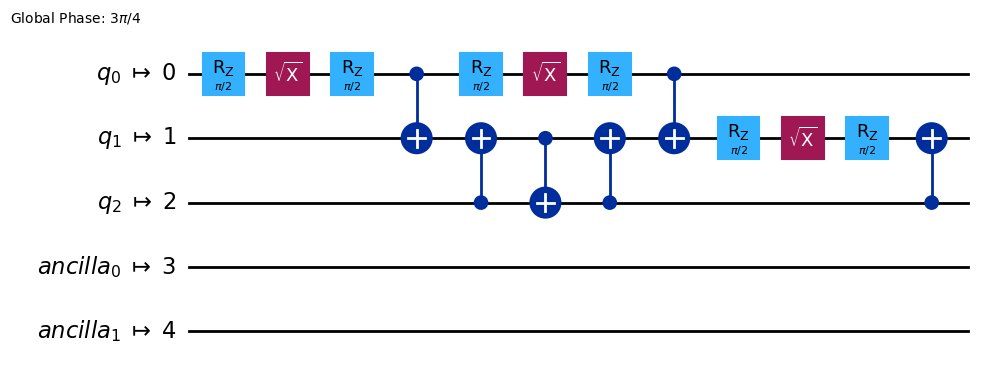

In [260]:
transpiletime1 = transpile(circuit0, backend=backendtime1, optimization_level=0)
transpiletime1.draw('mpl')

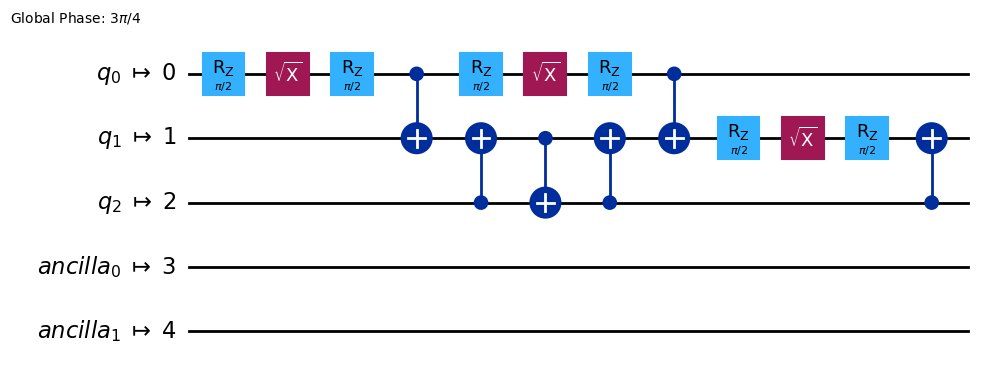

In [261]:
transpiletime2 = transpile(circuit0, backend=backendtime0, optimization_level=0)
transpiletime2.draw('mpl')

In [262]:
for i in list_backend_a:
    print(i.name)
    transpiled_circuit0 = transpile(circuit0, backend=i, optimization_level=0,scheduling_method="asap")
    print(transpiled_circuit0.duration)

fake_bogota
15968
fake_athens
9376


/tmp/ipykernel_338479/4186789268.py:4: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(transpiled_circuit0.duration)
/tmp/ipykernel_338479/4186789268.py:4: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(transpiled_circuit0.duration)


Duration Results:
       backend backend_clean  duration
0  fake_bogota        Bogota     15968
1  fake_athens        Athens      9376


/tmp/ipykernel_338479/484705557.py:14: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  'duration': transpiled_circuit0.duration
/tmp/ipykernel_338479/484705557.py:14: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  'duration': transpiled_circuit0.duration


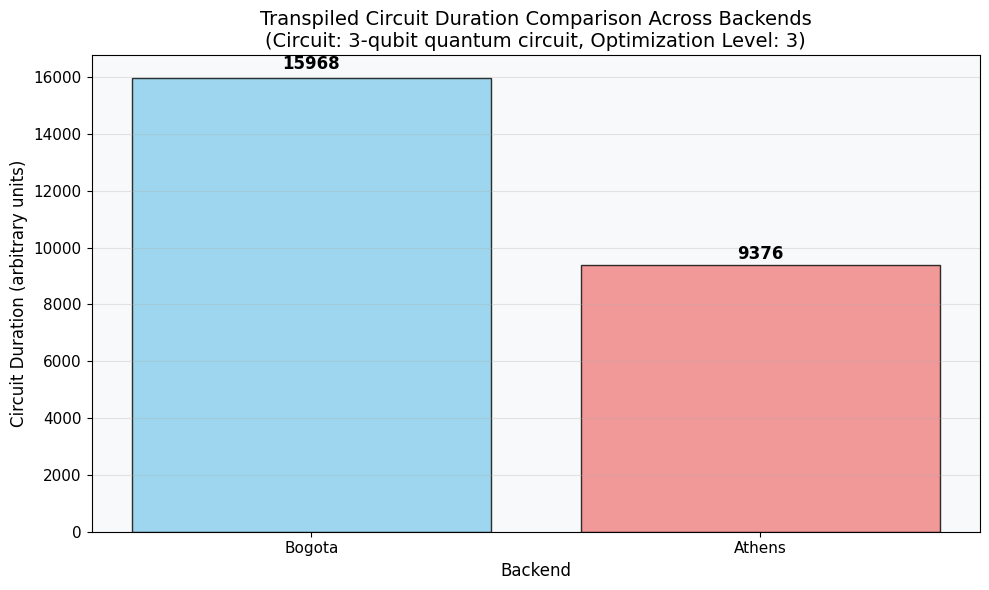


Summary Statistics:
Average duration: 12672.0
Duration range: 9376 - 15968
Duration ratio (max/min): 1.70x


In [263]:
# Collect duration data for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collect duration data
duration_results = []

for backend in list_backend_a:
    transpiled_circuit0 = transpile(circuit0, backend=backend, optimization_level=3, scheduling_method="asap")
    duration_results.append({
        'backend': backend.name,
        'backend_clean': backend.name.replace('fake_', '').title(),
        'duration': transpiled_circuit0.duration
    })

# Convert to DataFrame
df_duration = pd.DataFrame(duration_results)

print("Duration Results:")
print(df_duration)

# Create visualization
plt.figure(figsize=(10, 6))

# Bar chart of durations
bars = plt.bar(df_duration['backend_clean'], df_duration['duration'], 
               color=['skyblue', 'lightcoral'], alpha=0.8, edgecolor='black')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Backend', fontsize=12)
plt.ylabel('Circuit Duration (arbitrary units)', fontsize=12)
plt.title('Transpiled Circuit Duration Comparison Across Backends\n(Circuit: 3-qubit quantum circuit, Optimization Level: 3)', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Add some styling
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Add a subtle background color
plt.gca().set_facecolor('#f8f9fa')

plt.tight_layout()

# Save the plot
plt.savefig('img/circuit_duration_comparison.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Average duration: {df_duration['duration'].mean():.1f}")
print(f"Duration range: {df_duration['duration'].min()} - {df_duration['duration'].max()}")
print(f"Duration ratio (max/min): {df_duration['duration'].max() / df_duration['duration'].min():.2f}x")

/tmp/ipykernel_338479/2247402769.py:15: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  'duration': transpiled_circuit.duration
/tmp/ipykernel_338479/2247402769.py:15: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  'duration': transpiled_circuit.duration
/tmp/ipykernel_338479/2247402769.py:15: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  'duration': transpiled_circuit.duration
/tmp/ipykernel_338479/2247402769.py:15: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  'duration': transpiled_circuit.duration
/tmp/ipykernel_338479/224740

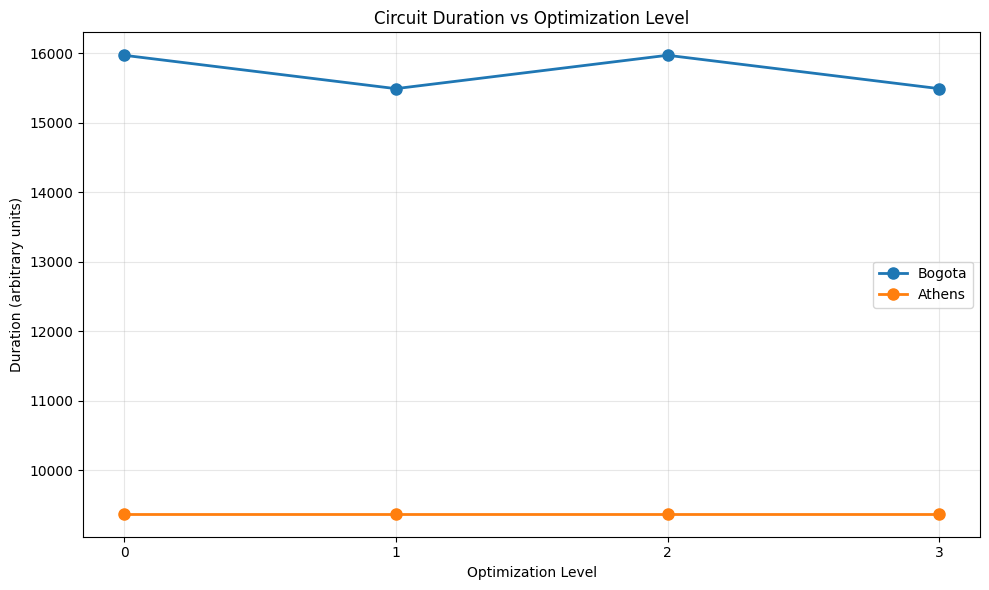

<Figure size 1000x600 with 0 Axes>

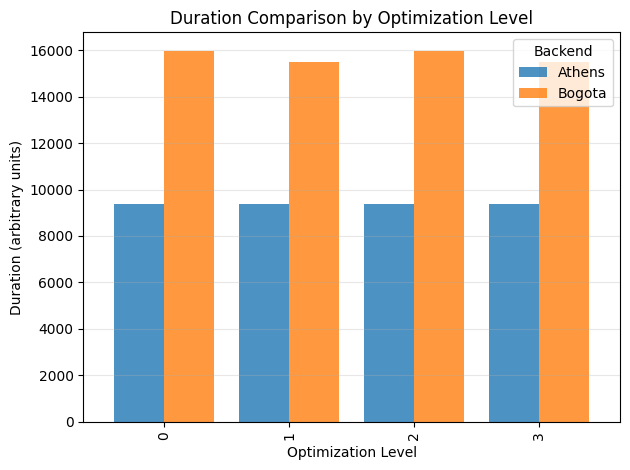

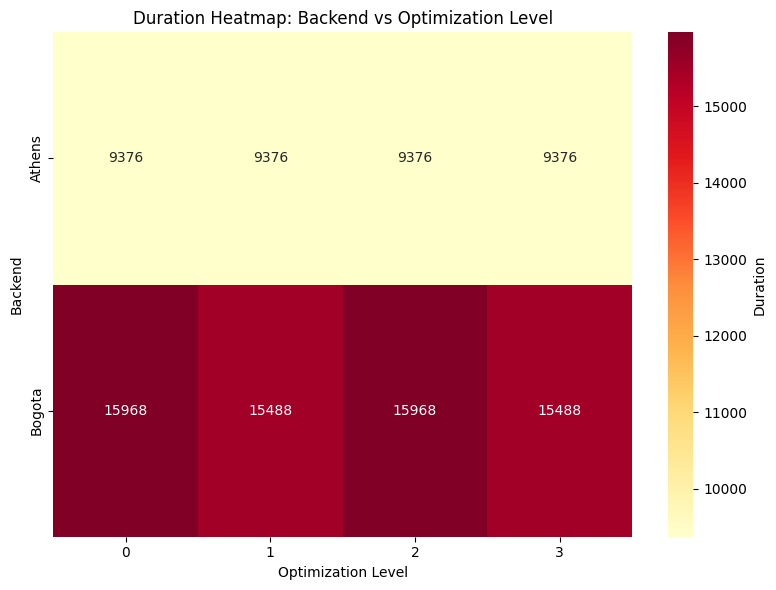

<Figure size 800x600 with 0 Axes>

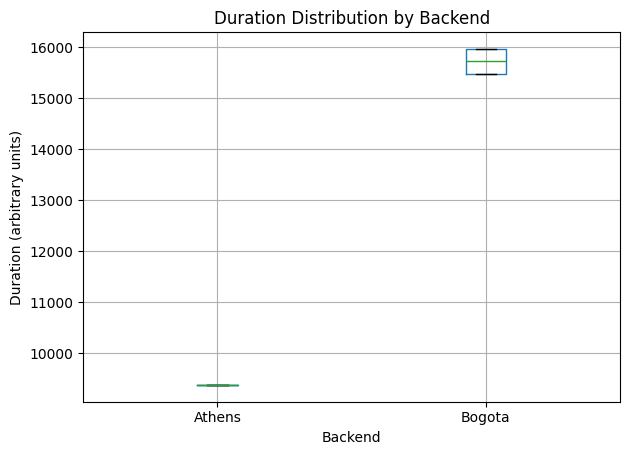

Detailed Duration Statistics:
                            count     mean  std      min      25%      50%  \
backend optimization_level                                                   
Athens  0                     1.0   9376.0  NaN   9376.0   9376.0   9376.0   
        1                     1.0   9376.0  NaN   9376.0   9376.0   9376.0   
        2                     1.0   9376.0  NaN   9376.0   9376.0   9376.0   
        3                     1.0   9376.0  NaN   9376.0   9376.0   9376.0   
Bogota  0                     1.0  15968.0  NaN  15968.0  15968.0  15968.0   
        1                     1.0  15488.0  NaN  15488.0  15488.0  15488.0   
        2                     1.0  15968.0  NaN  15968.0  15968.0  15968.0   
        3                     1.0  15488.0  NaN  15488.0  15488.0  15488.0   

                                75%      max  
backend optimization_level                    
Athens  0                    9376.0   9376.0  
        1                    9376.0   9376.0  
 

In [264]:
# Extended analysis: Duration across optimization levels
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Collect duration data across optimization levels
extended_duration_results = []

for backend in list_backend_a:
    for opt_level in [0, 1, 2, 3]:
        transpiled_circuit = transpile(circuit0, backend=backend, optimization_level=opt_level, scheduling_method="asap")
        extended_duration_results.append({
            'backend': backend.name.replace('fake_', '').title(),
            'optimization_level': opt_level,
            'duration': transpiled_circuit.duration
        })

# Convert to DataFrame
df_extended = pd.DataFrame(extended_duration_results)

# Plot 1: Line plot showing duration vs optimization level
plt.figure(figsize=(10, 6))
for backend in df_extended['backend'].unique():
    backend_data = df_extended[df_extended['backend'] == backend]
    plt.plot(backend_data['optimization_level'], backend_data['duration'], 
             marker='o', linewidth=2, markersize=8, label=backend)

plt.xlabel('Optimization Level')
plt.ylabel('Duration (arbitrary units)')
plt.title('Circuit Duration vs Optimization Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks([0, 1, 2, 3])
plt.tight_layout()
plt.savefig('img/duration_vs_optimization_level.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plot 2: Bar chart grouped by optimization level
plt.figure(figsize=(10, 6))
pivot_data = df_extended.pivot(index='optimization_level', columns='backend', values='duration')
pivot_data.plot(kind='bar', width=0.8, alpha=0.8)
plt.xlabel('Optimization Level')
plt.ylabel('Duration (arbitrary units)')
plt.title('Duration Comparison by Optimization Level')
plt.legend(title='Backend')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('img/duration_bar_chart_by_optimization.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plot 3: Heatmap
plt.figure(figsize=(8, 6))
heatmap_data = df_extended.pivot(index='backend', columns='optimization_level', values='duration')
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Duration'})
plt.title('Duration Heatmap: Backend vs Optimization Level')
plt.xlabel('Optimization Level')
plt.ylabel('Backend')
plt.tight_layout()
plt.savefig('img/duration_heatmap.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Plot 4: Box plot showing distribution
plt.figure(figsize=(8, 6))
df_extended.boxplot(column='duration', by='backend')
plt.xlabel('Backend')
plt.ylabel('Duration (arbitrary units)')
plt.title('Duration Distribution by Backend')
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig('img/duration_boxplot.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Print detailed statistics
print("Detailed Duration Statistics:")
print("="*50)
summary_stats = df_extended.groupby(['backend', 'optimization_level'])['duration'].describe()
print(summary_stats)

print("\nOptimization Level Impact:")
print("="*30)
opt_impact = df_extended.groupby('optimization_level')['duration'].mean()
print(opt_impact)

print("\nBackend Performance Summary:")
print("="*30)
backend_summary = df_extended.groupby('backend')['duration'].agg(['mean', 'std', 'min', 'max'])
print(backend_summary)

In [265]:
# Load and clean the quantum algorithms results data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the quantum algorithms results
df_quantum = pd.read_csv('quantum_algorithms_results.csv')

# Remove rows with missing values
df_quantum_clean = df_quantum.dropna()

# Calculate depth increase factor
df_quantum_clean['depth_increase_factor'] = df_quantum_clean['transpiled_depth'] / df_quantum_clean['original_depth']

# Sort by original depth for better visualization
df_quantum_clean = df_quantum_clean.sort_values('original_depth')

print(f"Loaded {len(df_quantum)} algorithms, {len(df_quantum_clean)} have complete data")
print(f"Algorithms with missing data: {list(df_quantum[df_quantum.isnull().any(axis=1)]['algorithm_name'])}")
print("\nData preview:")
print(df_quantum_clean.head())

# Visualization 1: Original vs Transpiled Depth Comparison
plt.figure(figsize=(15, 10))  # Increased height to accommodate labels

# Create a bar chart showing original vs transpiled depths
x = np.arange(len(df_quantum_clean))
width = 0.35

bars1 = plt.bar(x - width/2, df_quantum_clean['original_depth'], width, 
                label='Original Depth', alpha=0.8, color='lightblue')
bars2 = plt.bar(x + width/2, df_quantum_clean['transpiled_depth'], width, 
                label='Transpiled Depth', alpha=0.8, color='lightcoral')

# Add value labels on top of bars with better positioning
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Original depth values
    height1 = bar1.get_height()
    plt.text(bar1.get_x() + bar1.get_width()/2., height1 * 1.1,  # Increased multiplier for better spacing
             f'{int(df_quantum_clean.iloc[i]["original_depth"])}', 
             ha='center', va='bottom', fontsize=7, rotation=90)  # Rotated text and smaller font
    
    # Transpiled depth values
    height2 = bar2.get_height()
    plt.text(bar2.get_x() + bar2.get_width()/2., height2 * 1.1,  # Increased multiplier for better spacing
             f'{int(df_quantum_clean.iloc[i]["transpiled_depth"])}', 
             ha='center', va='bottom', fontsize=7, rotation=90)  # Rotated text and smaller font

plt.xlabel('Quantum Algorithms')
plt.ylabel('Circuit Depth')
plt.title('Original vs Transpiled Circuit Depth for Quantum Algorithms')
plt.xticks(x, df_quantum_clean['algorithm_name'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Use log scale due to large differences in depth

# Adjust y-axis limits to accommodate the labels
ax = plt.gca()
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax * 2)  # Increase upper limit to give space for labels

plt.tight_layout()
# save
plt.savefig('img/original_vs_transpiled_depth.pdf')
plt.show()

# Print some statistics
print(f"Average original depth: {df_quantum_clean['original_depth'].mean():.1f}")
print(f"Average transpiled depth: {df_quantum_clean['transpiled_depth'].mean():.1f}")
print(f"Average depth increase factor: {df_quantum_clean['depth_increase_factor'].mean():.1f}x")

FileNotFoundError: [Errno 2] No such file or directory: 'quantum_algorithms_results.csv'